<a href="https://colab.research.google.com/github/magician-Jackson/cup/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [19]:
!pip install keras-tcn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
from tcn import TCN
plt.style.use('seaborn')
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
np.random.seed(100)

In [20]:
#设置神经网络参数
batch_size=64#批训练大小
epoch=50#迭代次数
test_ratio=.33#测试集比例
windows=2#时间窗
scale=1.0#归一化参数

#读取数据
data = pd.read_csv('data.csv').iloc[:,1:]
data = data.drop(['Volume'], axis = 1)
print(data.tail())
#把数据处理成lstm接受的输入形式
y=data['Close']
data = np.array(data)/scale
cut = round(test_ratio* data.shape[0])
amount_of_features=data.shape[1]
lstm_input=[]
data_temp=data
for i in range(len(data_temp)-windows):
    lstm_input.append(data_temp[i:i+windows,:])
lstm_input=np.array(lstm_input)
#print(lstm_input.shape)
lstm_output=y[:-windows]
lstm_output=np.array(lstm_output)
#print(lstm_output.shape)
x_train,y_train,x_test,y_test=\
lstm_input[:-cut,:,:],lstm_output[:-cut:],lstm_input[-cut:,:,:],lstm_output[-cut:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

             Open         High          Low    Adj Close        Close
1254  3579.310059  3581.229980  3556.850098  3557.540039  3557.540039
1255  3566.820068  3589.810059  3552.770020  3577.590088  3577.590088
1256  3594.520020  3642.310059  3594.520020  3635.409912  3635.409912
1257  3635.500000  3635.500000  3617.760010  3629.649902  3629.649902
1258  3638.550049  3644.310059  3629.330078  3638.350098  3638.350098
(842, 2, 5)
(415, 2, 5)
(842,)
(415,)


# TCN

In [21]:
def tcn_model():
  #建立模型
  inputs=Input(shape=(windows,amount_of_features))
  tcn = TCN(nb_filters=amount_of_features)(inputs)
  outputs = Dense(1, activation='linear')(tcn)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile('adam','mae')
  model.summary()#展示模型结构
  return model

def tcn_att_model():
  #建立模型
  inputs = Input(shape=(windows,amount_of_features))
  tcn_inputs=Permute([2,1])(inputs)
  tcn = TCN(nb_filters=amount_of_features)(inputs)
  attention=Dense(amount_of_features, activation='sigmoid', name='attention_vec')(tcn)#求解Attention权重
  attention=Activation('softmax',name='attention_weight')(attention)
  tcn=Multiply()([tcn, attention])#attention与LSTM对应数值相乘
  outputs = Dense(1, activation='linear')(tcn)
  model = Model(inputs=inputs, outputs=outputs)
  model.summary()
  model.compile('adam','mae')
  return model
  
def mape(y_true, y_pred):
  #评价指标MAPE
  record=[]
  for index in range(len(y_true)):
    if abs(y_true[index])>10:
      temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
      record.append(temp_mape)
  return np.mean(record) * 100

def easy_result(y_train,y_train_predict,train_index):
  #进行反归一化
  #y_train_predict=np.reshape(y_train_predict, (-1,1))  
  #y_train_predict= mm_y.inverse_transform(y_train_predict)
  y_train_predict=y_train_predict[:,0]
  #y_train=np.reshape(y_train, (-1,1))  
  #y_train=mm_y.inverse_transform(y_train)
  #y_train=y_train[:,0]
  #画图进行展示
  plt.figure(figsize=(10,5))
  plt.plot(y_train[:])
  plt.plot(y_train_predict[:])
  plt.legend(('real', 'predict'),fontsize='15')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  print('\n')
  plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
  plot_x=np.linspace(plot_begin,plot_end,10)
  plt.figure(figsize=(5,5))
  plt.plot(plot_x,plot_x)
  plt.plot(y_train,y_train_predict,'o')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  #输出结果
  print('%s上的MAE/RMSE/MAPE/R^2'%train_index)
  print(mean_absolute_error(y_train, y_train_predict))
  print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
  print(mape(y_train, y_train_predict) )
  print(r2_score(y_train, y_train_predict))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 5)]            0         
                                                                 
 tcn_1 (TCN)                 (None, 5)                 960       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 966
Trainable params: 966
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
12/12 - 7s - loss: 247.9146 - val_loss: 117.2573 - 7s/epoch - 560ms/step
Epoch 2/50
12/12 - 0s - loss: 56.8827 - val_loss: 65.2908 - 244ms/epoch - 20ms/step
Epoch 3/50
12/12 - 0s - loss: 29.8744 - val_loss: 24.5132 - 253ms/epoch - 21ms/step
Epoch 4/50
12/12 - 0s - loss: 14.1972 - val_loss: 18.4657 - 263ms/epoch -

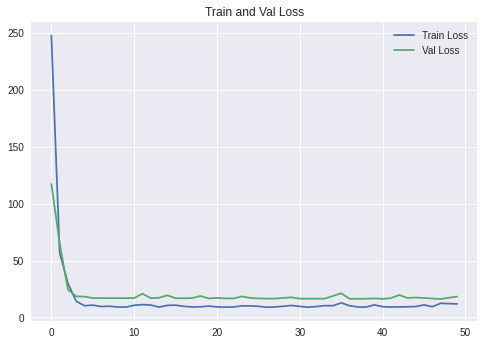

In [22]:
#运行
myModel = tcn_model()#建立模型
history = myModel.fit(x=x_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epoch,
                      verbose=2,
                      validation_split=0.1)
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [ ]:
y_train_predict=myModel.predict(x_train)#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标 
y_test_predict=myModel.predict(x_test)#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标

# GRU

In [ ]:
rnn_units=16
dropout = 0.01
#from tensorflow.keras.layers import Dropout
def gru_model():
  #建立模型
  inputs=Input(shape=(windows,amount_of_features))
  rnn=GRU(rnn_units, activation='relu',return_sequences=False)(inputs)
  dense=Dropout(dropout)(rnn)#droupout层
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile('adam','mae')
  model.summary()#展示模型结构
  return model

#运行
myModel = gru_model()#建立模型
history = myModel.fit(x=x_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epoch,
                      verbose=2,
                      validation_split=0.1)
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

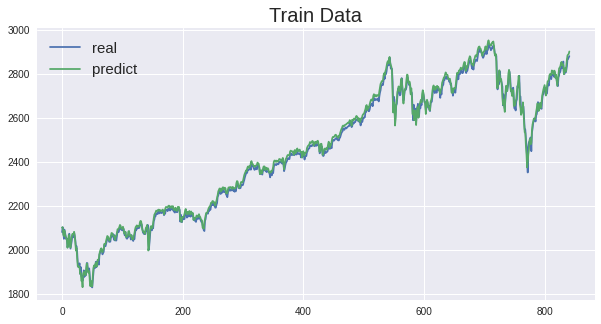

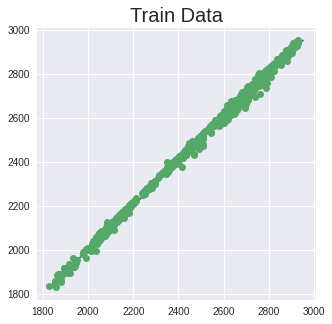

Train上的MAE/RMSE/MAPE/R^2
13.920157172942027
16.362008383067156
0.5675185061777124
0.996835396920695


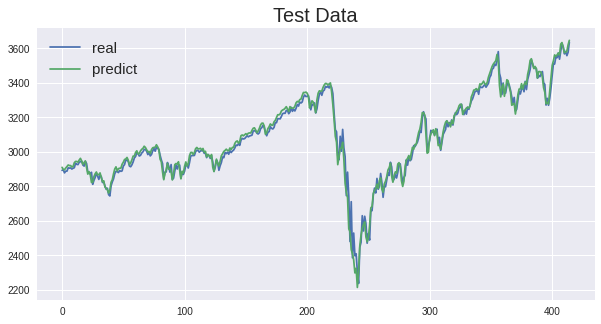

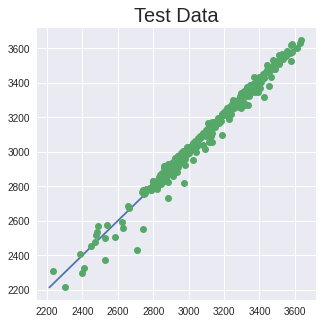

Test上的MAE/RMSE/MAPE/R^2
23.608311372251503
34.460069888159246
0.784966726354763
0.9805588553827879


In [23]:
y_train_predict=myModel.predict(x_train)#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标 
y_test_predict=myModel.predict(x_test)#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标

# LSTM

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2, 5)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                1408      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
12/12 - 2s - loss: 2413.1711 - val_loss: 2694.2058 - 2s/epoch - 131ms/step
Epoch 2/50
12/12 - 0s - loss: 2412.0374 - val_loss: 2694.2058 - 63ms/epoch - 5ms/step
Epoch 3/50
12/12 

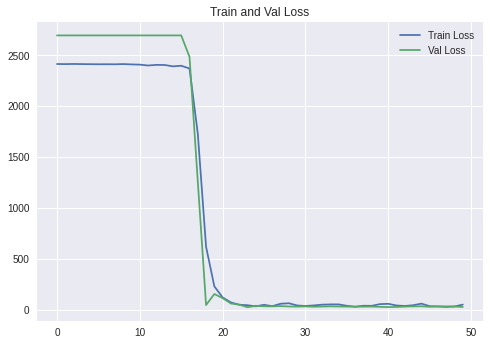

In [24]:
def lstm_model():
  #建立模型
  inputs=Input(shape=(windows,amount_of_features))
  rnn=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs)
  dense=Dropout(dropout)(rnn)#droupout层
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile('adam','mae')
  model.summary()#展示模型结构
  return model

#运行
myModel = lstm_model()#建立模型
history = myModel.fit(x=x_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epoch,
                      verbose=2,
                      validation_split=0.1)
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

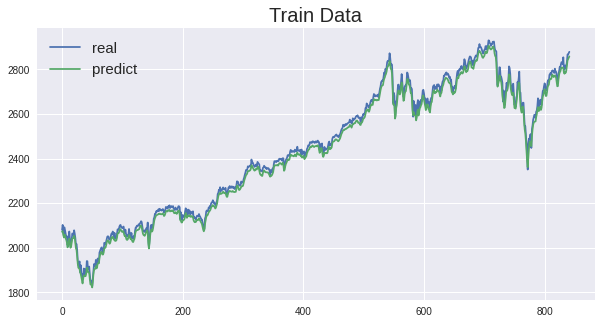

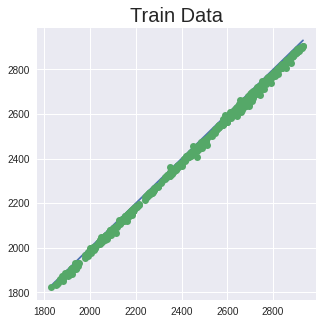

Train上的MAE/RMSE/MAPE/R^2
20.52808616049028
21.830436313320792
0.8405581506422286
0.9943665965387467


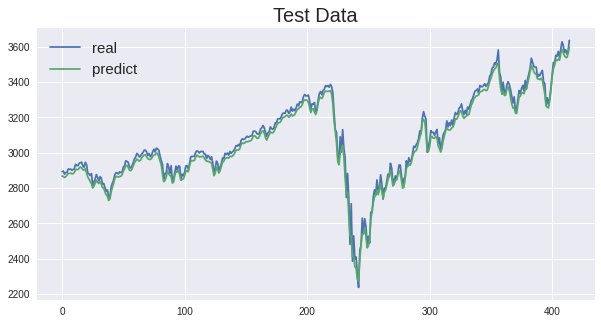

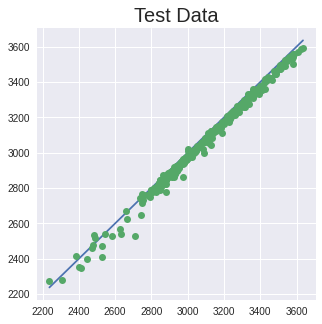

Test上的MAE/RMSE/MAPE/R^2
28.607920169728914
33.460490301907896
0.9368676603350198
0.9816703520389469


In [25]:
y_train_predict=myModel.predict(x_train)#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标 
y_test_predict=myModel.predict(x_test)#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标

# GBDT

In [31]:
x = data[:-1]
y_ = y.values[1:]
x_train,y_train,x_test,y_test=\
x[:-cut],y_[:-cut],x[-cut:],y_[-cut:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(843, 5)
(415, 5)
(843,)
(415,)


In [32]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
myModel = reg.fit(x_train, y_train) 
def easy_result(y_train,y_train_predict,train_index):
  #进行反归一化
  #y_train_predict=np.reshape(y_train_predict, (-1,1))  
  #y_train_predict= mm_y.inverse_transform(y_train_predict)
  #y_train_predict=y_train_predict[:,0]
  #y_train=np.reshape(y_train, (-1,1))  
  #y_train=mm_y.inverse_transform(y_train)
  #y_train=y_train[:,0]
  #画图进行展示
  plt.figure(figsize=(10,5))
  plt.plot(y_train[:])
  plt.plot(y_train_predict[:])
  plt.legend(('real', 'predict'),fontsize='15')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  print('\n')
  plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
  plot_x=np.linspace(plot_begin,plot_end,10)
  plt.figure(figsize=(5,5))
  plt.plot(plot_x,plot_x)
  plt.plot(y_train,y_train_predict,'o')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  #输出结果
  print('%s上的MAE/RMSE/MAPE/R^2'%train_index)
  print(mean_absolute_error(y_train, y_train_predict))
  print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
  print(mape(y_train, y_train_predict) )
  print(r2_score(y_train, y_train_predict))

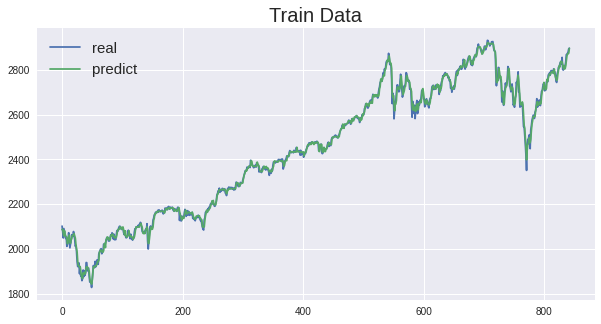

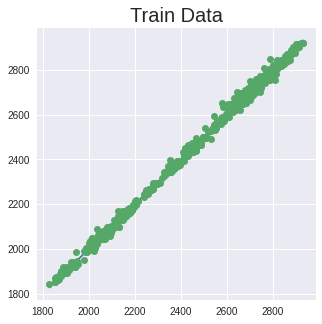

Train上的MAE/RMSE/MAPE/R^2
9.906906617661743
14.039509895319043
0.40596488642554945
0.9976762392854251


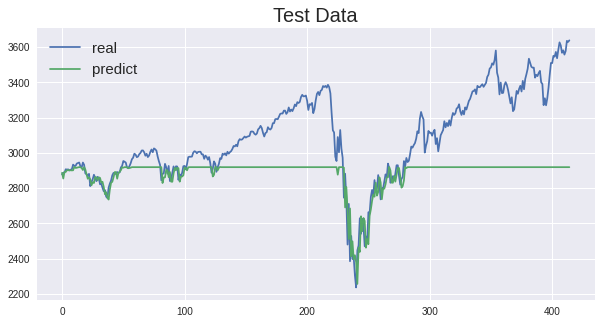

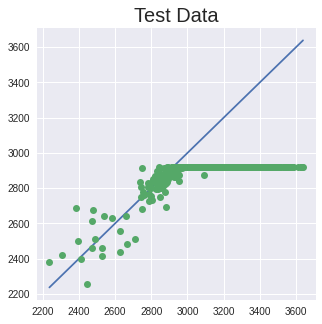

Test上的MAE/RMSE/MAPE/R^2
211.07263012008477
285.0072524718198
6.461189982246639
-0.30228189746526857


In [33]:
y_train_predict=myModel.predict(x_train)#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标 
y_test_predict=myModel.predict(x_test)#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标